# Variational Autoencoder for the not-MNIST dataset

We will use a probabilisitc non-linear generative model for the not-MNIST dataset. Unlike the localization example, we will train both the **generative model parameters** and the parameters of the **amortized variaitonal family**.

----

<img src="genmodel.png" style="width: 800px;">


---

----

<img src="infermodel.png" style="width: 800px;">


---


## ELBO lower-bound to $p(\mathbf{X})$

<img src="ELBO.png" style="width: 800px;">

Where $\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right)+\left(\mu_{\eta}(\mathbf{x})^T\mu_{\eta}(\mathbf{x})\right)-2-\log\det \left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right) \right]
\end{align}

## SGD optimization

- Sample a M-size minibatch of images.
- Sample $\mathbf{\epsilon}^{(i)}$ from $\mathcal{N}(\mathbf{0},\mathbf{I})$, $i=1,\ldots,M$.
- For $i=1,\ldots,M$, compute
\begin{align}
\mathbf{z}^{(i)} = \mu_\eta(\mathbf{x}^{(i)}) + \sqrt{\text{diag}(\sigma_\eta(\mathbf{x}^{(i)}))} \circ \mathbf{\epsilon}^{(i)}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\eta) =\sum_{i=1}^M \Big(\log  p_\theta(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) - \text{KL}(q_{\eta,\mathbf{x}^{(i)}}(\mathbf{z})||p(\mathbf{z}))\Big)
\end{align}
w.r.t. $\theta,\eta$
- Perform SGD update




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# use seaborn plotting defaults
import seaborn as sns; sns.set()

%matplotlib inline

/Users/olmos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading MNIST database

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata('MNIST original')

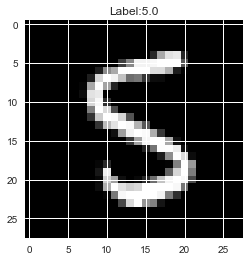

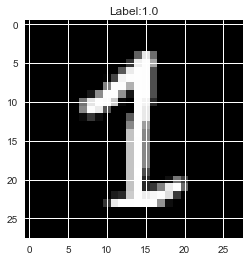

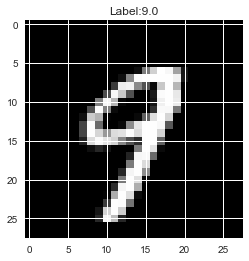

In [3]:
images = mnist.data.astype(np.float32)
labels = mnist.target

train_dataset,test_dataset,train_labels,test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

train_dataset,valid_dataset,train_labels,valid_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

#Generate a random index
num_figs=3
img_size = 28

index=np.random.randint(train_dataset.shape[0], size=num_figs)

for i in range(num_figs):
    plt.figure()
    plt.imshow(train_dataset[index[i],:].reshape([28,28]),cmap=plt.cm.gray)
    plt.title('Label:' + str(train_labels[index[i]]))

### TensorFlow Computation Graph and Loss Function

In [11]:
z_dim = 2      #Latent Space

model_name = 'model1'   #In 'model1.py' we define the variational family

learning_rate = 1e-3
num_imgs = 50        #Number of samples generated from the generative model (for testing)
num_iter = 20000      #SGD iterations
period_plot = 1000   
sigma_reconstruction = 0.01 #Reconstruction variance
batch_size = 200
dims = [batch_size,784]

In [12]:
sess_VAE = tf.Graph()

with sess_VAE.as_default():
    
    print('[*] Importing model: ' + model_name)
    model = __import__(model_name)
    
    print('[*] Defining placeholders')

    inputX = tf.placeholder(tf.float32, shape=dims, name='x-input')
    
    print('[*] Defining the encoder')
    log_var, mean, sample_z, KL = model.encoder(inputX,z_dim,batch_size)
        
    print('[*] Defining the decoder')
    
    loglik,img_reconstruction = model.decoder(inputX,sample_z,sigma_reconstruction,dims[1])  
        
    loss = -tf.reduce_mean(loglik - KL)
    
    optim = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    print('[*] Defining Sample operation...')
    samples = model.new_samples(num_imgs, z_dim, dims[1])  
    
    # Output dictionary -> Useful if computation graph is defined in a separate .py file
    
    tf_nodes = {}
    
    tf_nodes['X'] = inputX
    
    tf_nodes['mean'] = mean
    
    tf_nodes['logvar'] = log_var

    tf_nodes['KL'] = tf.reduce_mean(KL)
    
    tf_nodes['loglik'] = tf.reduce_mean(loglik)
    
    tf_nodes['img_reconst'] = img_reconstruction
    
    tf_nodes['optim'] = optim
    
    tf_nodes['samples'] = samples
    

[*] Importing model: model1
[*] Defining placeholders
[*] Defining the encoder
[*] Defining the decoder
[*] Defining Sample operation...


## SGD optimization

In [13]:
   
############ SGD Inference #####################################

with tf.Session(graph=sess_VAE) as session:
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    tf.global_variables_initializer().run()
        
    print('Training the VAE ...')    
    
    for it in range(num_iter):
        
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        
        offset = (it * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feedDict = {tf_nodes['X'] : batch_data.reshape([-1,784])}  

        _,loglik,KL= session.run([tf_nodes['optim'],tf_nodes['loglik'],tf_nodes['KL']],feedDict)

        if(it % period_plot ==0):

            print("It = %d, loglik = %.5f, KL = %.5f" %(it,loglik,KL))


    it = 0
    offset = (it * batch_size) % (train_labels.shape[0] - batch_size)

    batch_data_train = train_dataset[offset:(offset + batch_size), :]
    batch_data_test = test_dataset[offset:(offset + batch_size), :]

    #We compute the latent representation of batch images and their reconstruction
    feedDict = {tf_nodes['X'] : batch_data_train.reshape([-1,784])} 
    z,reconstructions_train = session.run([tf_nodes['mean'],tf_nodes['img_reconst']], feed_dict=feedDict)

    feedDict = {tf_nodes['X'] : batch_data_test.reshape([-1,784])} 
    z_test,reconstructions_test = session.run([tf_nodes['mean'],tf_nodes['img_reconst']], feed_dict=feedDict)

    samples = session.run(tf_nodes['samples'])


Training the VAE ...
It = 0, loglik = -294680416.00000, KL = 2.37981
It = 1000, loglik = -170337856.00000, KL = 14.90301
It = 2000, loglik = -162173904.00000, KL = 17.67475
It = 3000, loglik = -157364464.00000, KL = 17.43681
It = 4000, loglik = -151082656.00000, KL = 19.02109
It = 5000, loglik = -146750832.00000, KL = 19.01055
It = 6000, loglik = -144242784.00000, KL = 17.92510
It = 7000, loglik = -141732912.00000, KL = 18.24413
It = 8000, loglik = -138781984.00000, KL = 19.72985
It = 9000, loglik = -139642464.00000, KL = 19.51037
It = 10000, loglik = -140557952.00000, KL = 19.72429
It = 11000, loglik = -132590232.00000, KL = 18.34506
It = 12000, loglik = -133731248.00000, KL = 20.11160
It = 13000, loglik = -124924768.00000, KL = 20.37013
It = 14000, loglik = -124596776.00000, KL = 20.34818
It = 15000, loglik = -134286560.00000, KL = 20.94070
It = 16000, loglik = -127114336.00000, KL = 20.84480
It = 17000, loglik = -121211256.00000, KL = 19.79773
It = 18000, loglik = -121058880.00000, 

### Lets plot some train images and their reconstruction

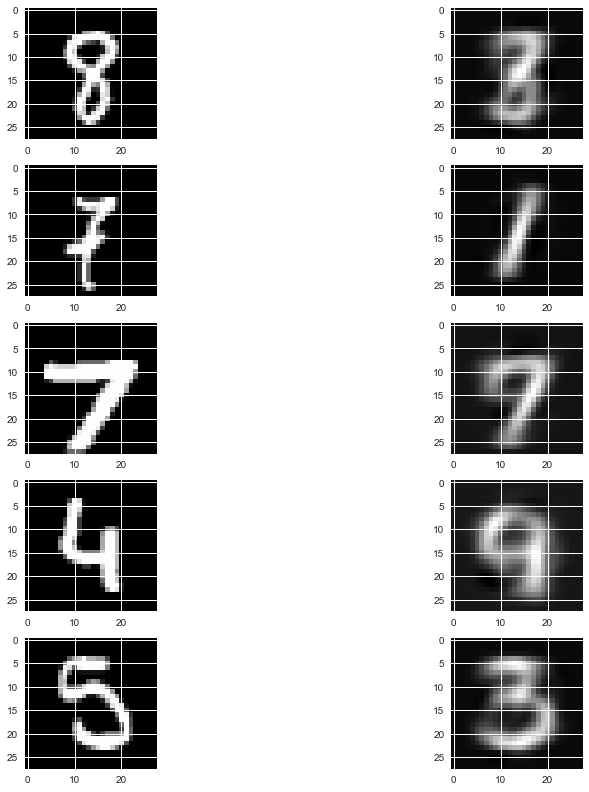

In [14]:
#Lets plot train images and their reconstruction

n_plots_axis=5

f2, axarr2 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr2[i,0].imshow(batch_data_train[i,:].reshape([28,28]),cmap='gray');
    axarr2[i,1].imshow(reconstructions_train[i,:].reshape([28,28]),cmap='gray') 
    

### Lets plot latent representation of train images

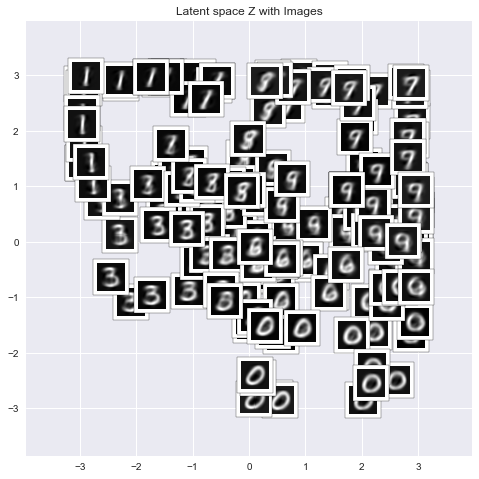

In [15]:
def plot_latent_space_with_images(ax,recons_images,z_samples):
    
    ax.clear()
    for i in range(len(recons_images)):
        im = OffsetImage(recons_images[i].reshape([28,28]), zoom=1,cmap='gray')
        ab = AnnotationBbox(im, z_samples[i],frameon=True)
        ax.add_artist(ab)
    ax.set_xlim(np.min(z_samples[:,0])-1,np.max(z_samples[:,0])+1)
    ax.set_ylim(np.min(z_samples[:,1])-1,np.max(z_samples[:,1])+1)
    ax.set_title('Latent space Z with Images')
    
plt.figure()
f_latent, ax_latent = plt.subplots(1,1,figsize=(8, 8))
plot_latent_space_with_images(ax_latent,reconstructions_train,z) 
plt.rcParams["figure.figsize"] = [14,14]

### Lets plot latent representation of test images

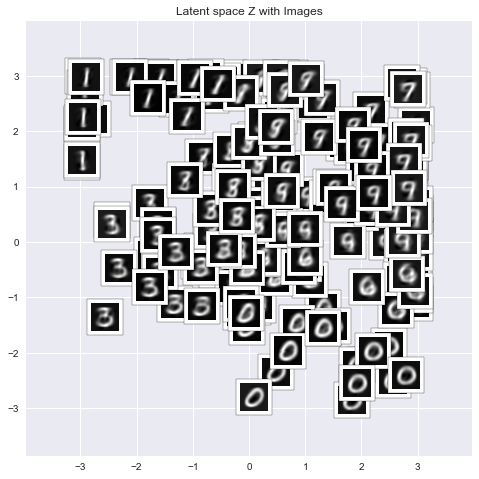

In [16]:
plt.figure()
f_latent, ax_latent = plt.subplots(1,1,figsize=(8, 8))
plot_latent_space_with_images(ax_latent,reconstructions_test,z_test) 
plt.rcParams["figure.figsize"] = [14,14]

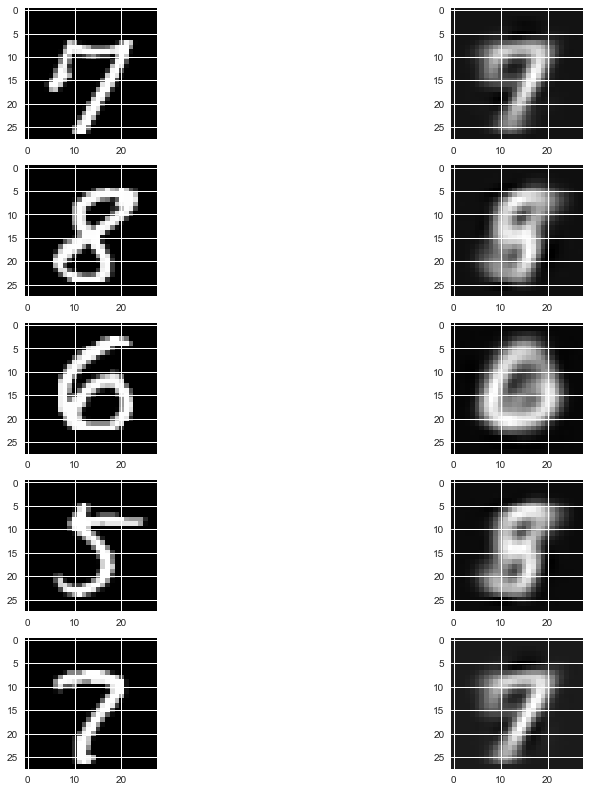

In [17]:
# Lets plot latent representation of test images

f3, axarr3 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr3[i,0].imshow(batch_data_test[i,:].reshape([28,28]),cmap='gray');
    axarr3[i,1].imshow(reconstructions_test[i,:].reshape([28,28]),cmap='gray')


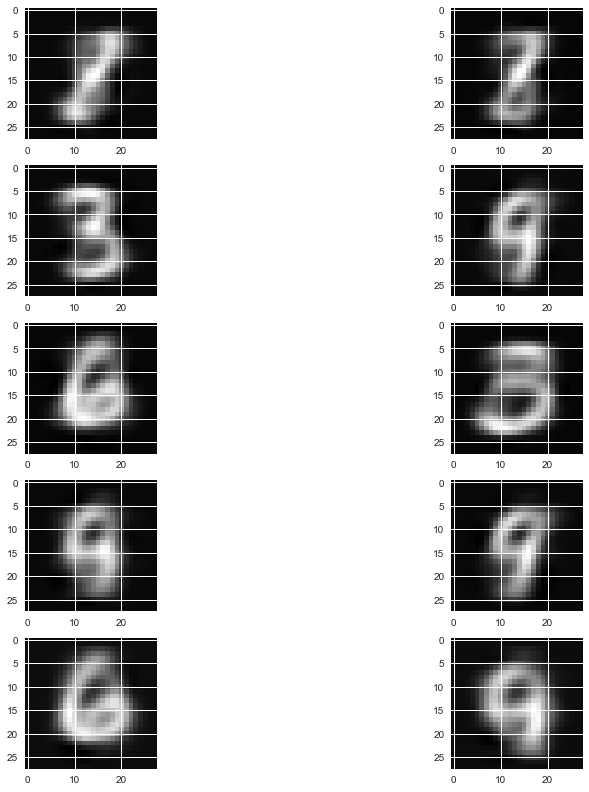

In [21]:
# Lets plot samples of the model


n_plots_axis=5

f4, axarr4 = plt.subplots(n_plots_axis,2)

for i in range(n_plots_axis):

    axarr4[i,0].imshow(samples[i,:].reshape([28,28]),cmap='gray');
    axarr4[i,1].imshow(samples[i+20,:].reshape([28,28]),cmap='gray') 
    